In [1]:
##### diagnostic
from Diagnostic_functions import *

In [2]:
##### parse parameter
import argparse

try:
    parser = argparse.ArgumentParser()

    parser.add_argument('-var_t', type=float, required=True,
        help='variable: pulse_duration [fs]')
    parser.add_argument('-var_E', type=float, required=True,
        help='variable: photon energy [eV]')
    parser.add_argument('-err_f1', type=float, required=True,
        help='error: crystal-lens distance [m]')
    parser.add_argument('-err_delta', type=float, required=True,
        help='error: crystal alignment [urad]')
    parser.add_argument('-err_miscut', type=float, required=True,
        help='error: crystal miscut [urad]')
    args = parser.parse_args()

    var_t = args.var_t
    var_E = args.var_E
    err_f1 = args.err_f1
    err_delta = args.err_delta
    err_miscut = args.err_miscut
    
except:
    var_t = 1200.
    var_E = 9481.
    err_f1 = 0.
    err_delta = 0.
    err_miscut = 0.
    
print('arguments: {}'.format([var_t, var_E, err_f1, err_delta, err_miscut]))


arguments: [1200.0, 9481.0, 0.0, 0.0, 0.0]


usage: ipykernel_launcher.py [-h] -var_t VAR_T -var_E VAR_E -err_f1 ERR_F1 -err_delta ERR_DELTA -err_miscut ERR_MISCUT
ipykernel_launcher.py: error: the following arguments are required: -var_t, -var_E, -err_f1, -err_delta, -err_miscut


In [3]:
##### sampling parameters
sigT = var_t * 1e-15/2.355
E = var_E
d_slit = 10e-6

t_res =sigT*2.355/10          # time sampling resolution [s]
t_window = sigT*2.355*40     # total time window [s]
ev_window = 4/t_res *1e-15   # total energy window [eV]

range_x = 4e-3; range_y = 4e-3
nx = 256; ny = 8; nz = 2*round(t_window/t_res/2)
ny_reduced = 8

x_res = range_x/nx
y_res = range_y/ny
ev_res = ev_window/nz        # energy sampling resolution [eV]

pulseRange = int(t_window/sigT)
factor = -1 # factor = 0.5

print('nx, ny, nz: {}'.format([nx, ny, nz]))
print('x resolution/range: {}/ {}um'.format(round(x_res*1e6,2), round(range_x*1e6,2)))
print('y resolution/range: {}/ {}um'.format(round(y_res*1e6,2), round(range_y*1e6,2)))
print('time resolution/range: {}/ {}fs'.format(round(t_res*1e15,2), round(t_window*1e15,2)))
print('energy resolution/range: {}/ {}meV'.format(round(ev_res*1e3,2), round(ev_window*1e3,2)))


def rCRL(fCRL, nCRL):
    # calculates the min radius of curvature of each lens
    return 7.58227e-06*fCRL/nCRL

# def rCRL(fCRL, nCRL):
#     # calculates the min radius of curvature of each lens
#     return 2.151005735797996e-06*fCRL/nCRL

fCRL0 = 290.; nCRL0 = 1
fCRL1 = 10.; nCRL1 = 1
fCRL2 = 10.; nCRL2 = 1

# I/O directories
dir_output = 'output/'
dir_case = dir_output+'Loop_f1/'
dir_param = dir_case+'{}fs/'.format(round(sigT*2.355*1e15,2))
dir_plot = dir_param+'{}fs_{}meV/'.format(round(t_window*1e15,1),round(ev_window*1e3,1))


nx, ny, nz: [256, 8, 400]
x resolution/range: 15.62/ 4000.0um
y resolution/range: 500.0/ 4000.0um
time resolution/range: 120.0/ 48000.0fs
energy resolution/range: 0.08/ 33.33meV


In [4]:
##### general crystal calculations
# Si 220
Si220 = srwlib.SRWLOptCryst(_d_sp=1.9201374688016222, _psi0r=-1.0873035035585694e-05, _psi0i=1.8438837339536554e-07,
                         _psi_hr=-6.610167427198717e-06, _psi_hi=1.7824173540780476e-07,
                         _psi_hbr=-6.610167427198717e-06, _psi_hbi=1.7824173540780476e-07,
                         _tc=0.01, _ang_as=0)

# Si 440
Si440 = srwlib.SRWLOptCryst(_d_sp=0.9600687344008111, _psi0r=-1.0873035035585694e-05, _psi0i=1.8438837339536554e-07,
                         _psi_hr=-4.181686438547451e-06, _psi_hi=1.6100412693351052e-07,
                         _psi_hbr=-4.181686438547451e-06, _psi_hbi=1.6100412693351052e-07,
                         _tc=0.01, _ang_as=0)


    
thetaB220 = Si220.get_ang_inc(_e=E)
thetaB440 = Si440.get_ang_inc(_e=E)

ang_asym_HHLM1 = np.deg2rad(17)
ang_asym_HHLM2 = np.deg2rad(-29.5)
ang_asym_HHLM3 = np.deg2rad(17)
ang_asym_HHLM4 = np.deg2rad(29.5)

In [13]:
##### beamline crystal calculations
''' input parameters '''
name_HHLM = ['HHLM1', 'HHLM2', 'HHLM3', 'HHLM4']
thetaB_list_HHLM = np.array([thetaB220, thetaB440, thetaB440, thetaB220])
ang_asym_list_HHLM = np.deg2rad([17, 0, 0, -17])
ang_dif_pl_list_HHLM = np.array([np.pi/2, -np.pi/2, np.pi/2, -np.pi/2])

name_HRM = ['C1', 'C2', 'C3', 'C4']
thetaB_list_HRM = np.array([thetaB440, thetaB440, thetaB440, thetaB440])
ang_asym_list_HRM = np.deg2rad([-29.5, 0, 0, 29.5])
ang_dif_pl_list_HRM = np.array([np.pi/2, -np.pi/2, -np.pi/2, np.pi/2])

''' var_param '''
nv_list_HHLM = []; tv_list_HHLM = []; ang_in_HHLM = []
for i in range(len(name_HHLM)):
    thetaB = thetaB_list_HHLM[i]
    ang_asym = ang_asym_list_HHLM[i]
    ang_dif_pl = ang_dif_pl_list_HHLM[i]
    nv, tv, ang_in = calc_crystal_orientation(thetaB, ang_asym, ang_dif_pl)
    nv_list_HHLM.append(nv)
    tv_list_HHLM.append(tv)
    ang_in_HHLM.append(ang_in)
    
nv_list_HRM = []; tv_list_HRM = []; ang_in_HRM = []
for i in range(len(name_HRM)):
    thetaB = thetaB_list_HRM[i]
    ang_asym = ang_asym_list_HRM[i]
    ang_dif_pl = ang_dif_pl_list_HRM[i]
    nv, tv, ang_in = calc_crystal_orientation(thetaB, ang_asym, ang_dif_pl)
    nv_list_HRM.append(nv)
    tv_list_HRM.append(tv)
    ang_in_HRM.append(ang_in)

In [ ]:
##### beamline crystal scaling factor calculations
thetaB1 = thetaB220; thetaB2 = thetaB440
ang_asym1 = np.deg2rad(17); ang_asym2 = np.deg2rad(-29.5)

b_factor1 = calc_b_factor(thetaB1,ang_asym1)
b_factor2 = calc_b_factor(thetaB2,ang_asym2)

x_scaling1 = calc_scale_factor(b_factor1)
x_scaling2 = calc_scale_factor(b_factor2)
t_stretching1 = calc_t_stretching(thetaB1, ang_asym1, range_x=range_x)
t_stretching2 = calc_t_stretching(thetaB2, ang_asym2, range_x=range_x)
z_scaling1 = np.max([np.round(t_stretching1/t_window),1.])
z_scaling2 = np.max([np.round(t_stretching2/t_window),1.])

print('HHLM1 Bragg angle: {}degree'.format(np.rad2deg(thetaB1)))
print('  b factor: {}, range_x multiplication factor: {}'.format(round(b_factor1, 2), x_scaling1))
print('  pulse stretching: {}fs, nz scaling factor: {}'.format(round(t_stretching1*1e15,2), z_scaling1))
print('nx, ny, nz: {}\n'.format([nx*x_scaling1, ny, nz*z_scaling1]))

print('HHLM2 Bragg angle: {}degree'.format(np.rad2deg(thetaB2)))
print('  b factor: {}, range_x multiplication factor: {}'.format(round(b_factor2, 2), x_scaling2))
print('  pulse stretching: {}fs, nz scaling factor: {}'.format(round(t_stretching2*1e15,2), z_scaling2))
print('nx, ny, nz: {}\n'.format([nx*x_scaling2, ny, nz*z_scaling2]))

deviation_angle = [thetaB1*2, (thetaB2-thetaB1)*2, thetaB1*2]

drift_list = []
pos_beam = [0]
posx = [0]
for i in range(len(zlist)-1):
    driftz = posz[i+1]-posz[i]
    drift = driftz/np.cos(deviation_angle[i])
    drift_list.append(drift)
    pos_beam.append(pos_beam[i]+drift)
    driftx = driftz*np.tan(deviation_angle[i])*(-1)**i
    posx.append(posx[-1]+driftx)
    
# visualisation
plt.figure()
plt.plot((np.append(posz, max(posz)+0.1)-posz[0])*1e3, np.append(posx, posx[-1])*1e3,label='pulse between crystals')
plt.plot((np.asarray([min(posz)-0.1,max(posz)+0.1])-posz[0])*1e3,[0,0],'--',label='incident beam direction')
plt.legend()
plt.xlabel('z (mm)')
plt.ylabel('x (mm)')
plt.axis('equal')

print('drift between crystals (mm): {}'.format(np.asarray(drift_list)))
print('crystal positions (m): {}\n'.format(pos_beam))


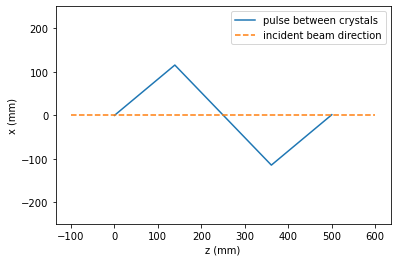

In [10]:
##### HHLM crystal geometry calculations
''' HHLM positions '''
zlist = np.array([0, 139, 361, 500])    # crystal position in lab frame [mm]

# beam direction calculation
for i in range(len(zlist)):
    # loop through crystals and calculates beam direction
    if i == 0:
        v_in = [0,0,1]
        v_out = calc_direction_output(v_in, thetaB_list_HHLM[i], ang_dif_pl = ang_dif_pl_list_HHLM[i])
        beam_dir_HHLM = np.array([v_out])
    else:
        v_in = beam_dir_HHLM[i-1]
        v_out = calc_direction_output(v_in, thetaB_list_HHLM[i], ang_dif_pl = ang_dif_pl_list_HHLM[i])
        beam_dir_HHLM = np.append(beam_dir_HHLM, [v_out], axis=0)

# beam path calculation
driftz = zlist[1:] - zlist[:-1]
drift_list = []
beam_pos = np.zeros([1,3])

for i in range(len(driftz)):
    beam_dir = beam_dir_HHLM[i]
    drift = driftz[i]/beam_dir[-1]
    drift_list = np.append(drift_list, drift)
    beam_pos = np.append(beam_pos, [beam_pos[i]+drift*beam_dir], axis=0)

# visualisation
plt.figure()
plt.plot(beam_pos[:,-1], -beam_pos[:,0],label='pulse between crystals')
plt.plot((np.asarray([min(beam_pos[:,-1])-100,max(beam_pos[:,-1])+100])),[0,0],'--',label='incident beam direction')
plt.legend(); plt.xlabel('z (mm)'); plt.ylabel('x (mm)'); plt.axis('equal')
    
''' HHLM, HRM scaling factors'''
thetaB_list_HRM = np.array([thetaB220, thetaB440, thetaB440, thetaB220])
ang_asym_list_HRM = np.deg2rad([17, 0, 0, -17])
ang_dif_pl_list_HRM = np.array([np.pi/2, -np.pi/2, np.pi/2, -np.pi/2])


In [ ]:
# I/O
def mkdir(path):
    if not os.path.exists(path):
        os.mkdir(path)

mkdir(dir_output)
mkdir(dir_case)
mkdir(dir_param)
mkdir(dir_plot)

In [ ]:
## define bl HHLM
def set_optics_CRL0(v=None):
    el = []
    pp = []
    names = ['CRL','CRL_HHLM1']
    for el_name in names:
        if el_name == 'CRL':
            # CRL: crl 290.0m
            el.append(srwlib.srwl_opt_setup_CRL(
                _foc_plane=v.op_CRL_foc_plane,
                _delta=v.op_CRL_delta,
                _atten_len=v.op_CRL_atten_len,
                _shape=v.op_CRL_shape,
                _apert_h=v.op_CRL_apert_h,
                _apert_v=v.op_CRL_apert_v,
                _r_min=v.op_CRL_r_min,
                _n=v.op_CRL_n,
                _wall_thick=v.op_CRL_wall_thick,
                _xc=v.op_CRL_x,
                _yc=v.op_CRL_y,
            ))
            pp.append(v.op_CRL_pp)
        elif el_name == 'CRL_HHLM1':
            # CRL_HHLM1: drift 290.0m
            el.append(srwlib.SRWLOptD(
                _L=v.op_CRL_HHLM1_L,
            ))
            pp.append(v.op_CRL_HHLM1_pp)
    return srwlib.SRWLOptC(el, pp)

def set_optics_HHLM1(v=None):
    el = []
    pp = []
    names = ['HHLM1']
    for el_name in names:
        if el_name == 'HHLM1':
            # HHLM1: crystal 295.0m
            crystal = srwlib.SRWLOptCryst(
                _d_sp=v.op_HHLM1_d_sp,
                _psi0r=v.op_HHLM1_psi0r,
                _psi0i=v.op_HHLM1_psi0i,
                _psi_hr=v.op_HHLM1_psiHr,
                _psi_hi=v.op_HHLM1_psiHi,
                _psi_hbr=v.op_HHLM1_psiHBr,
                _psi_hbi=v.op_HHLM1_psiHBi,
                _tc=v.op_HHLM1_tc,
                _ang_as=v.op_HHLM1_ang_as,
                _nvx=v.op_HHLM1_nvx,
                _nvy=v.op_HHLM1_nvy,
                _nvz=v.op_HHLM1_nvz,
                _tvx=v.op_HHLM1_tvx,
                _tvy=v.op_HHLM1_tvy,
                _uc=v.op_HHLM1_uc,
                _e_avg=v.op_HHLM1_energy,
                _ang_roll=v.op_HHLM1_diffractionAngle
            )
            el.append(crystal)
            pp.append(v.op_HHLM1_pp)
    return srwlib.SRWLOptC(el, pp)

def set_optics_HHLM2(v=None, drift=.2):
    el = []
    pp = []
    names = ['HHLM1_HHLM2', 'HHLM2']
    for el_name in names:
        if el_name == 'HHLM1_HHLM2':
            # HHLM1_HHLM2: drift
            el.append(srwlib.SRWLOptD(
#                 _L=v.op_HHLM1_HHLM2_L,
                _L = drift
            ))
            pp.append(v.op_HHLM1_HHLM2_pp)
        elif el_name == 'HHLM2':
            # HHLM2: crystal
            crystal = srwlib.SRWLOptCryst(
                _d_sp=v.op_HHLM2_d_sp,
                _psi0r=v.op_HHLM2_psi0r,
                _psi0i=v.op_HHLM2_psi0i,
                _psi_hr=v.op_HHLM2_psiHr,
                _psi_hi=v.op_HHLM2_psiHi,
                _psi_hbr=v.op_HHLM2_psiHBr,
                _psi_hbi=v.op_HHLM2_psiHBi,
                _tc=v.op_HHLM2_tc,
                _ang_as=v.op_HHLM2_ang_as,
                _nvx=v.op_HHLM2_nvx,
                _nvy=v.op_HHLM2_nvy,
                _nvz=v.op_HHLM2_nvz,
                _tvx=v.op_HHLM2_tvx,
                _tvy=v.op_HHLM2_tvy,
                _uc=v.op_HHLM2_uc,
                _e_avg=v.op_HHLM2_energy,
                _ang_roll=v.op_HHLM2_diffractionAngle
            )
            el.append(crystal)
            pp.append(v.op_HHLM2_pp)
    return srwlib.SRWLOptC(el, pp)

def set_optics_HHLM3(v=None, drift=.2):
    el = []
    pp = []
    names = ['HHLM2_HHLM3', 'HHLM3']
    for el_name in names:
        if el_name == 'HHLM2_HHLM3':
            # HHLM2_HHLM3: drift
            el.append(srwlib.SRWLOptD(
#                 _L=v.op_HHLM1_HHLM2_L,
                _L = drift
            ))
            pp.append(v.op_HHLM2_HHLM3_pp)
        elif el_name == 'HHLM3':
            # HHLM3: crystal
            crystal = srwlib.SRWLOptCryst(
                _d_sp=v.op_HHLM3_d_sp,
                _psi0r=v.op_HHLM3_psi0r,
                _psi0i=v.op_HHLM3_psi0i,
                _psi_hr=v.op_HHLM3_psiHr,
                _psi_hi=v.op_HHLM3_psiHi,
                _psi_hbr=v.op_HHLM3_psiHBr,
                _psi_hbi=v.op_HHLM3_psiHBi,
                _tc=v.op_HHLM3_tc,
                _ang_as=v.op_HHLM3_ang_as,
                _nvx=v.op_HHLM3_nvx,
                _nvy=v.op_HHLM3_nvy,
                _nvz=v.op_HHLM3_nvz,
                _tvx=v.op_HHLM3_tvx,
                _tvy=v.op_HHLM3_tvy,
                _uc=v.op_HHLM3_uc,
                _e_avg=v.op_HHLM3_energy,
                _ang_roll=v.op_HHLM3_diffractionAngle
            )
            el.append(crystal)
            pp.append(v.op_HHLM3_pp)
    return srwlib.SRWLOptC(el, pp)


def set_optics_HHLM4(v=None, drift=.2):
    el = []
    pp = []
    names = ['HHLM3_HHLM4', 'HHLM4', 'HHLM4_After_HHLM', 'After_HHLM']
    for el_name in names:
        if el_name == 'HHLM3_HHLM4':
            # HHLM3_HHLM4: drift
            el.append(srwlib.SRWLOptD(
#                 _L=v.op_HHLM1_HHLM2_L,
                _L = drift
            ))
            pp.append(v.op_HHLM3_HHLM4_pp)
        elif el_name == 'HHLM4':
            # HHLM4: crystal
            crystal = srwlib.SRWLOptCryst(
                _d_sp=v.op_HHLM4_d_sp,
                _psi0r=v.op_HHLM4_psi0r,
                _psi0i=v.op_HHLM4_psi0i,
                _psi_hr=v.op_HHLM4_psiHr,
                _psi_hi=v.op_HHLM4_psiHi,
                _psi_hbr=v.op_HHLM4_psiHBr,
                _psi_hbi=v.op_HHLM4_psiHBi,
                _tc=v.op_HHLM4_tc,
                _ang_as=v.op_HHLM4_ang_as,
                _nvx=v.op_HHLM4_nvx,
                _nvy=v.op_HHLM4_nvy,
                _nvz=v.op_HHLM4_nvz,
                _tvx=v.op_HHLM4_tvx,
                _tvy=v.op_HHLM4_tvy,
                _uc=v.op_HHLM4_uc,
                _e_avg=v.op_HHLM4_energy,
                _ang_roll=v.op_HHLM4_diffractionAngle
            )
            el.append(crystal)
            pp.append(v.op_HHLM4_pp)
#         elif el_name == 'HHLM4_After_HHLM':
#             # HHLM4_After_HHLM: drift 301.2m
#             el.append(srwlib.SRWLOptD(
#                 _L=v.op_HHLM4_After_HHLM_L,
#             ))
#             pp.append(v.op_HHLM4_After_HHLM_pp)
#         elif el_name == 'After_HHLM':
#             # After_HHLM: watch 310.1m
#             pass
#     pp.append(v.op_fin_pp)
    return srwlib.SRWLOptC(el, pp)


In [ ]:
## define bl HRM
def set_optics_CC1(v=None, drift=5.0):
    el = []
    pp = []
    names = ['HHLM4_C1', 'C1', 'C1_C2', 'C2']
    for el_name in names:
        if el_name == 'HHLM4_C1':
            # CRL_C1: drift 290.0m
            el.append(srwlib.SRWLOptD(
#                 _L=v.op_HHLM4_C1_L,
                _L=drift,
            ))
            pp.append(v.op_HHLM4_C1_pp)
        elif el_name == 'C1':
            # C1: crystal 300.0m
            crystal = srwlib.SRWLOptCryst(
                _d_sp=v.op_C1_d_sp,
                _psi0r=v.op_C1_psi0r,
                _psi0i=v.op_C1_psi0i,
                _psi_hr=v.op_C1_psiHr,
                _psi_hi=v.op_C1_psiHi,
                _psi_hbr=v.op_C1_psiHBr,
                _psi_hbi=v.op_C1_psiHBi,
                _tc=v.op_C1_tc,
                _ang_as=v.op_C1_ang_as,
                _nvx=v.op_C1_nvx,
                _nvy=v.op_C1_nvy,
                _nvz=v.op_C1_nvz,
                _tvx=v.op_C1_tvx,
                _tvy=v.op_C1_tvy,
                _uc=v.op_C1_uc,
                _e_avg=v.op_C1_energy,
                _ang_roll=v.op_C1_diffractionAngle
            )
            el.append(crystal)
            pp.append(v.op_C1_pp)

        elif el_name == 'C1_C2':
            # C1_C2: drift 300.0m
            el.append(srwlib.SRWLOptD(
                _L=v.op_C1_C2_L,
            ))
            pp.append(v.op_C1_C2_pp)
        elif el_name == 'C2':
            # C2: crystal 300.2m
            crystal = srwlib.SRWLOptCryst(
                _d_sp=v.op_C2_d_sp,
                _psi0r=v.op_C2_psi0r,
                _psi0i=v.op_C2_psi0i,
                _psi_hr=v.op_C2_psiHr,
                _psi_hi=v.op_C2_psiHi,
                _psi_hbr=v.op_C2_psiHBr,
                _psi_hbi=v.op_C2_psiHBi,
                _tc=v.op_C2_tc,
                _ang_as=v.op_C2_ang_as,
                _nvx=v.op_C2_nvx,
                _nvy=v.op_C2_nvy,
                _nvz=v.op_C2_nvz,
                _tvx=v.op_C2_tvx,
                _tvy=v.op_C2_tvy,
                _uc=v.op_C2_uc,
                _e_avg=v.op_C2_energy,
                _ang_roll=v.op_C2_diffractionAngle
            )
            el.append(crystal)
            pp.append(v.op_C2_pp)
    return srwlib.SRWLOptC(el, pp)


def set_optics_CC1_focus(v=None, f1=10.):
    el = []
    pp = []
    names = ['C2_CRL1', 'CRL1', 'CRL1_Slit']
    for el_name in names:
        if el_name == 'C2_CRL1':
            # C2_CRL1: drift 300.2m
            el.append(srwlib.SRWLOptD(
                # _L=v.op_C2_CRL1_L,
                _L=f1,
            ))
            pp.append(v.op_C2_CRL1_pp)
        elif el_name == 'CRL1':
            # CRL1: crl 310.2m
            el.append(srwlib.srwl_opt_setup_CRL(
                _foc_plane=v.op_CRL1_foc_plane,
                _delta=v.op_CRL1_delta,
                _atten_len=v.op_CRL1_atten_len,
                _shape=v.op_CRL1_shape,
                _apert_h=v.op_CRL1_apert_h,
                _apert_v=v.op_CRL1_apert_v,
                _r_min=v.op_CRL1_r_min,
                _n=v.op_CRL1_n,
                _wall_thick=v.op_CRL1_wall_thick,
                _xc=v.op_CRL1_x,
                _yc=v.op_CRL1_y,
            ))
            pp.append(v.op_CRL1_pp)
        elif el_name == 'CRL1_Slit':
            # CRL1_Slit: drift 310.2m
            el.append(srwlib.SRWLOptD(
                _L=v.op_CRL1_Slit_L,
            ))
            pp.append(v.op_CRL1_Slit_pp)
    return srwlib.SRWLOptC(el, pp)


def set_optics_slit(v=None, xc=0, yc=0):
    el = []
    pp = []
    names = ['Slit']
    for el_name in names:
        if el_name == 'Slit':
            # Slit: aperture 320.2m
            el.append(srwlib.SRWLOptA(
                _shape=v.op_Slit_shape,
                _ap_or_ob='a',
                _Dx=v.op_Slit_Dx,
                _Dy=v.op_Slit_Dy,
                _x=xc,
                _y=yc,
            ))
            pp.append(v.op_Slit_pp)
    return srwlib.SRWLOptC(el, pp)


def set_optics_focus_CC2(v=None, f1=10.):
    el = []
    pp = []
    names = ['Slit_CRL2', 'CRL2', 'CRL2_C3']
    for el_name in names:
        if el_name == 'Slit_CRL2':
            # Slit_CRL2: drift 320.2m
            el.append(srwlib.SRWLOptD(
                _L=v.op_Slit_CRL2_L,
            ))
            pp.append(v.op_Slit_CRL2_pp)
        elif el_name == 'CRL2':
            # CRL2: crl 330.2m
            el.append(srwlib.srwl_opt_setup_CRL(
                _foc_plane=v.op_CRL2_foc_plane,
                _delta=v.op_CRL2_delta,
                _atten_len=v.op_CRL2_atten_len,
                _shape=v.op_CRL2_shape,
                _apert_h=v.op_CRL2_apert_h,
                _apert_v=v.op_CRL2_apert_v,
                _r_min=v.op_CRL2_r_min,
                _n=v.op_CRL2_n,
                _wall_thick=v.op_CRL2_wall_thick,
                _xc=v.op_CRL2_x,
                _yc=v.op_CRL2_y,
            ))
            pp.append(v.op_CRL2_pp)
        elif el_name == 'CRL2_C3':
            # CRL2_C3: drift 330.2m
            el.append(srwlib.SRWLOptD(
                # _L=v.op_CRL2_C3_L,
                _L=f1,
            ))
            pp.append(v.op_CRL2_C3_pp)
    return srwlib.SRWLOptC(el, pp)


def set_optics_CC2(v=None):
    el = []
    pp = []
    names = ['C3', 'C3_C4', 'C4', 'C4_After_HRM', 'After_HRM']
    for el_name in names:
        if el_name == 'C3':
            # C3: crystal 340.2m
            crystal = srwlib.SRWLOptCryst(
                _d_sp=v.op_C3_d_sp,
                _psi0r=v.op_C3_psi0r,
                _psi0i=v.op_C3_psi0i,
                _psi_hr=v.op_C3_psiHr,
                _psi_hi=v.op_C3_psiHi,
                _psi_hbr=v.op_C3_psiHBr,
                _psi_hbi=v.op_C3_psiHBi,
                _tc=v.op_C3_tc,
                _ang_as=v.op_C3_ang_as,
                _nvx=v.op_C3_nvx,
                _nvy=v.op_C3_nvy,
                _nvz=v.op_C3_nvz,
                _tvx=v.op_C3_tvx,
                _tvy=v.op_C3_tvy,
                _uc=v.op_C3_uc,
                _e_avg=v.op_C3_energy,
                _ang_roll=v.op_C3_diffractionAngle
            )
            el.append(crystal)
            pp.append(v.op_C3_pp)

        elif el_name == 'C3_C4':
            # C3_C4: drift 340.2m
            el.append(srwlib.SRWLOptD(
                _L=v.op_C3_C4_L,
            ))
            pp.append(v.op_C3_C4_pp)
        elif el_name == 'C4':
            # C4: crystal 340.4m
            crystal = srwlib.SRWLOptCryst(
                _d_sp=v.op_C4_d_sp,
                _psi0r=v.op_C4_psi0r,
                _psi0i=v.op_C4_psi0i,
                _psi_hr=v.op_C4_psiHr,
                _psi_hi=v.op_C4_psiHi,
                _psi_hbr=v.op_C4_psiHBr,
                _psi_hbi=v.op_C4_psiHBi,
                _tc=v.op_C4_tc,
                _ang_as=v.op_C4_ang_as,
                _nvx=v.op_C4_nvx,
                _nvy=v.op_C4_nvy,
                _nvz=v.op_C4_nvz,
                _tvx=v.op_C4_tvx,
                _tvy=v.op_C4_tvy,
                _uc=v.op_C4_uc,
                _e_avg=v.op_C4_energy,
                _ang_roll=v.op_C4_diffractionAngle
            )
            el.append(crystal)
            pp.append(v.op_C4_pp)

#         elif el_name == 'C4_After_HRM':
#             # C4_After_HRM: drift 340.4m
#             el.append(srwlib.SRWLOptD(
#                 _L=v.op_C4_After_HRM_L,
#             ))
#             pp.append(v.op_C4_After_HRM_pp)
#         elif el_name == 'After_HRM':
#             # After_HRM: watch 350.4m
#             pass
    pp.append(v.op_fin_pp)
    return srwlib.SRWLOptC(el, pp)


In [ ]:
varParam = srwl_bl.srwl_uti_ext_options([
    ['name', 's', 'full_beamline', 'simulation name'],

#---Data Folder
    ['fdir', 's', '', 'folder (directory) name for reading-in input and saving output data files'],


    ['gbm_x', 'f', 0.0, 'average horizontal coordinates of waist [m]'],
    ['gbm_y', 'f', 0.0, 'average vertical coordinates of waist [m]'],
    ['gbm_z', 'f', 0.0, 'average longitudinal coordinate of waist [m]'],
    ['gbm_xp', 'f', 0.0, 'average horizontal angle at waist [rad]'],
    ['gbm_yp', 'f', 0.0, 'average verical angle at waist [rad]'],
    ['gbm_ave', 'f', 9481.0, 'average photon energy [eV]'],
    ['gbm_pen', 'f', 0.001, 'energy per pulse [J]'],
    ['gbm_rep', 'f', 1, 'rep. rate [Hz]'],
    ['gbm_pol', 'f', 2, 'polarization 1- lin. hor., 2- lin. vert., 3- lin. 45 deg., 4- lin.135 deg., 5- circ. right, 6- circ. left'],
    ['gbm_sx', 'f', 9.787229999999999e-06, 'rms beam size vs horizontal position [m] at waist (for intensity)'],
    ['gbm_sy', 'f', 9.787229999999999e-06, 'rms beam size vs vertical position [m] at waist (for intensity)'],
    ['gbm_st', 'f', sigT, 'rms pulse duration [s] (for intensity)'],
    ['gbm_mx', 'f', 0, 'transverse Gauss-Hermite mode order in horizontal direction'],
    ['gbm_my', 'f', 0, 'transverse Gauss-Hermite mode order in vertical direction'],
    ['gbm_ca', 's', 'c', 'treat _sigX, _sigY as sizes in [m] in coordinate representation (_presCA="c") or as angular divergences in [rad] in angular representation (_presCA="a")'],
    ['gbm_ft', 's', 't', 'treat _sigT as pulse duration in [s] in time domain/representation (_presFT="t") or as bandwidth in [eV] in frequency domain/representation (_presFT="f")'],

#---Calculation Types
    #Single-Electron Intensity distribution vs horizontal and vertical position
    ['si', '', '', 'calculate single-e intensity distribution (without wavefront propagation through a beamline) vs horizontal and vertical position', 'store_true'],
    #Single-Electron Wavefront Propagation
    ['ws', '', '', 'calculate single-electron (/ fully coherent) wavefront propagation', 'store_true'],
    #Multi-Electron (partially-coherent) Wavefront Propagation
    ['wm', '', '', 'calculate multi-electron (/ partially coherent) wavefront propagation', 'store_true'],

    ['w_e', 'f', -pulseRange*sigT/2, 'photon energy [eV] for calculation of intensity distribution vs horizontal and vertical position'],
    ['w_ef', 'f', pulseRange*sigT/2, 'final photon energy [eV] for calculation of intensity distribution vs horizontal and vertical position'],
    ['w_ne', 'i', nz, 'number of points vs photon energy for calculation of intensity distribution'],
    ['w_x', 'f', 0.0, 'central horizontal position [m] for calculation of intensity distribution'],
    ['w_rx', 'f', range_x, 'range of horizontal position [m] for calculation of intensity distribution'],
    ['w_nx', 'i', nx, 'number of points vs horizontal position for calculation of intensity distribution'],
    ['w_y', 'f', 0.0, 'central vertical position [m] for calculation of intensity distribution vs horizontal and vertical position'],
    ['w_ry', 'f', range_y, 'range of vertical position [m] for calculation of intensity distribution vs horizontal and vertical position'],
    ['w_ny', 'i', ny, 'number of points vs vertical position for calculation of intensity distribution'],
    ['w_smpf', 'f', factor, 'sampling factor for calculation of intensity distribution vs horizontal and vertical position'],
    ['w_meth', 'i', 2, 'method to use for calculation of intensity distribution vs horizontal and vertical position: 0- "manual", 1- "auto-undulator", 2- "auto-wiggler"'],
    ['w_prec', 'f', 0.01, 'relative precision for calculation of intensity distribution vs horizontal and vertical position'],

    ['w_ft', 's', 't', 'presentation/domain: "f"- frequency (photon energy), "t"- time'],

    ['w_u', 'i', 2, 'electric field units: 0- arbitrary, 1- sqrt(Phot/s/0.1%bw/mm^2), 2- sqrt(J/eV/mm^2) or sqrt(W/mm^2), depending on representation (freq. or time)'],
    ['si_pol', 'i', 6, 'polarization component to extract after calculation of intensity distribution: 0- Linear Horizontal, 1- Linear Vertical, 2- Linear 45 degrees, 3- Linear 135 degrees, 4- Circular Right, 5- Circular Left, 6- Total'],
    ['si_type', 'i', 0, 'type of a characteristic to be extracted after calculation of intensity distribution: 0- Single-Electron Intensity, 1- Multi-Electron Intensity, 2- Single-Electron Flux, 3- Multi-Electron Flux, 4- Single-Electron Radiation Phase, 5- Re(E): Real part of Single-Electron Electric Field, 6- Im(E): Imaginary part of Single-Electron Electric Field, 7- Single-Electron Intensity, integrated over Time or Photon Energy'],
    
    ['si_fn', 's', 'res_int_se.dat', 'file name for saving calculated single-e intensity distribution (without wavefront propagation through a beamline) vs horizontal and vertical position'],
    ['si_pl', 's', '', 'plot the input intensity distributions in graph(s): ""- dont plot, "x"- vs horizontal position, "y"- vs vertical position, "xy"- vs horizontal and vertical position'],
    ['ws_fni', 's', 'res_int_pr_se.dat', 'file name for saving propagated single-e intensity distribution vs horizontal and vertical position'],
    ['ws_pl', 's', '', 'plot the resulting intensity distributions in graph(s): ""- dont plot, "x"- vs horizontal position, "y"- vs vertical position, "xy"- vs horizontal and vertical position'],

    #to add options
    ['op_r', 'f', 290.0, 'longitudinal position of the first optical element [m]'],
    # Former appParam:
    ['rs_type', 's', 'g', 'source type, (u) idealized undulator, (t), tabulated undulator, (m) multipole, (g) gaussian beam'],

#---Beamline optics:
    # CRL: crl
    ['op_CRL_foc_plane', 'f', 1, 'focalPlane'],
    ['op_CRL_delta', 'f', 3.791135e-06, 'refractiveIndex'],
    ['op_CRL_atten_len', 'f', 0.008387, 'attenuationLength'],
    ['op_CRL_shape', 'f', 1, 'shape'],
    ['op_CRL_apert_h', 'f', range_x, 'horizontalApertureSize'],
    ['op_CRL_apert_v', 'f', range_y, 'verticalApertureSize'],
    ['op_CRL_r_min', 'f', rCRL(fCRL0, nCRL0), 'tipRadius'],
    ['op_CRL_wall_thick', 'f', 5e-05, 'tipWallThickness'],
    ['op_CRL_x', 'f', 0.0, 'horizontalOffset'],
    ['op_CRL_y', 'f', 0.0, 'verticalOffset'],
    ['op_CRL_n', 'i', nCRL0, 'numberOfLenses'],

    # CRL_HHLM1: drift
    ['op_CRL_HHLM1_L', 'f', 5.0, 'length'],
    
    # HHLM1: crystal
    ['op_HHLM1_hfn', 's', '', 'heightProfileFile'],
    ['op_HHLM1_dim', 's', 'x', 'orientation'],
    ['op_HHLM1_d_sp', 'f', 1.9201374688016222, 'dSpacing'],
    ['op_HHLM1_psi0r', 'f', -1.0873035035585694e-05, 'psi0r'],
    ['op_HHLM1_psi0i', 'f', 1.8438837339536554e-07, 'psi0i'],
    ['op_HHLM1_psiHr', 'f', -6.610167427198717e-06, 'psiHr'],
    ['op_HHLM1_psiHi', 'f', 1.7824173540780476e-07, 'psiHi'],
    ['op_HHLM1_psiHBr', 'f', -6.610167427198717e-06, 'psiHBr'],
    ['op_HHLM1_psiHBi', 'f', 1.7824173540780476e-07, 'psiHBi'],
    ['op_HHLM1_tc', 'f', 0.01, 'crystalThickness'],
    ['op_HHLM1_uc', 'f', 1, 'useCase'],
    ['op_HHLM1_ang_as', 'f', 0.29670597283903605, 'asymmetryAngle'],
    ['op_HHLM1_nvx', 'f', -0.998705946701, 'nvx'],
    ['op_HHLM1_nvy', 'f', 6.786e-09, 'nvy'],
    ['op_HHLM1_nvz', 'f', -0.050856976162, 'nvz'],
    ['op_HHLM1_tvx', 'f', -0.050856976162, 'tvx'],
    ['op_HHLM1_tvy', 'f', 3.46e-10, 'tvy'],
    ['op_HHLM1_ang', 'f', 0.05087889763248938, 'grazingAngle'],
    ['op_HHLM1_amp_coef', 'f', 1.0, 'heightAmplification'],
    ['op_HHLM1_energy', 'f', 9481.0, 'energy'],
    ['op_HHLM1_diffractionAngle', 'f', 1.57079632, 'diffractionAngle'],

    # HHLM1_HHLM2: drift
    ['op_HHLM1_HHLM2_L', 'f', 0.1809747877899781, 'length'],

    # HHLM2: crystal
    ['op_HHLM2_hfn', 's', '', 'heightProfileFile'],
    ['op_HHLM2_dim', 's', 'x', 'orientation'],
    ['op_HHLM2_d_sp', 'f', 0.9600687344008111, 'dSpacing'],
    ['op_HHLM2_psi0r', 'f', -1.0873035035585694e-05, 'psi0r'],
    ['op_HHLM2_psi0i', 'f', 1.8438837339536554e-07, 'psi0i'],
    ['op_HHLM2_psiHr', 'f', -4.181686438547451e-06, 'psiHr'],
    ['op_HHLM2_psiHi', 'f', 1.6100412693351052e-07, 'psiHi'],
    ['op_HHLM2_psiHBr', 'f', -4.181686438547451e-06, 'psiHBr'],
    ['op_HHLM2_psiHBi', 'f', 1.6100412693351052e-07, 'psiHBi'],
    ['op_HHLM2_tc', 'f', 0.01, 'crystalThickness'],
    ['op_HHLM2_uc', 'f', 1, 'useCase'],
    ['op_HHLM2_ang_as', 'f', 0.0, 'asymmetryAngle'],
    ['op_HHLM2_nvx', 'f', 0.7322282430733594, 'nvx'],
    ['op_HHLM2_nvy', 'f', 4.975415277322606e-09, 'nvy'],
    ['op_HHLM2_nvz', 'f', -0.6810593219725439, 'nvz'],
    ['op_HHLM2_tvx', 'f', 0.6810593219725439, 'tvx'],
    ['op_HHLM2_tvy', 'f', 4.627727743855522e-09, 'tvy'],
    ['op_HHLM2_ang', 'f', 0.7492083731847909, 'grazingAngle'],
    ['op_HHLM2_amp_coef', 'f', 1.0, 'heightAmplification'],
    ['op_HHLM2_energy', 'f', 9481.0, 'energy'],
    ['op_HHLM2_diffractionAngle', 'f', -1.57079632, 'diffractionAngle'],

    # HHLM2_HHLM3: drift
    ['op_HHLM2_HHLM3_L', 'f', 0.31977349122354326, 'length'],

    # HHLM3: crystal
    ['op_HHLM3_hfn', 's', '', 'heightProfileFile'],
    ['op_HHLM3_dim', 's', 'x', 'orientation'],
    ['op_HHLM3_d_sp', 'f', 0.9600687344008111, 'dSpacing'],
    ['op_HHLM3_psi0r', 'f', -1.0873035035585694e-05, 'psi0r'],
    ['op_HHLM3_psi0i', 'f', 1.8438837339536554e-07, 'psi0i'],
    ['op_HHLM3_psiHr', 'f', -4.181686438547451e-06, 'psiHr'],
    ['op_HHLM3_psiHi', 'f', 1.6100412693351052e-07, 'psiHi'],
    ['op_HHLM3_psiHBr', 'f', -4.181686438547451e-06, 'psiHBr'],
    ['op_HHLM3_psiHBi', 'f', 1.6100412693351052e-07, 'psiHBi'],
    ['op_HHLM3_tc', 'f', 0.01, 'crystalThickness'],
    ['op_HHLM3_uc', 'f', 1, 'useCase'],
    ['op_HHLM3_ang_as', 'f', 0.0, 'asymmetryAngle'],
    ['op_HHLM3_nvx', 'f', -0.7322282430733594, 'nvx'],
    ['op_HHLM3_nvy', 'f', 4.975415277322606e-09, 'nvy'],
    ['op_HHLM3_nvz', 'f', -0.6810593219725439, 'nvz'],
    ['op_HHLM3_tvx', 'f', -0.6810593219725439, 'tvx'],
    ['op_HHLM3_tvy', 'f', 4.627727743855522e-09, 'tvy'],
    ['op_HHLM3_ang', 'f', 0.7492083731847909, 'grazingAngle'],
    ['op_HHLM3_amp_coef', 'f', 1.0, 'heightAmplification'],
    ['op_HHLM3_energy', 'f', 9481.0, 'energy'],
    ['op_HHLM3_diffractionAngle', 'f', 1.57079632, 'diffractionAngle'],

    # HHLM3_HHLM4: drift
    ['op_HHLM3_HHLM4_L', 'f', 0.18097478778651066, 'length'],

    # HHLM4: crystal
    ['op_HHLM4_hfn', 's', '', 'heightProfileFile'],
    ['op_HHLM4_dim', 's', 'x', 'orientation'],
    ['op_HHLM4_d_sp', 'f', 1.9201374688016222, 'dSpacing'],
    ['op_HHLM4_psi0r', 'f', -1.0873035035585694e-05, 'psi0r'],
    ['op_HHLM4_psi0i', 'f', 1.8438837339536554e-07, 'psi0i'],
    ['op_HHLM4_psiHr', 'f', -6.610167427198717e-06, 'psiHr'],
    ['op_HHLM4_psiHi', 'f', 1.7824173540780476e-07, 'psiHi'],
    ['op_HHLM4_psiHBr', 'f', -6.610167427198717e-06, 'psiHBr'],
    ['op_HHLM4_psiHBi', 'f', 1.7824173540780476e-07, 'psiHBi'],
    ['op_HHLM4_tc', 'f', 0.01, 'crystalThickness'],
    ['op_HHLM4_uc', 'f', 1, 'useCase'],
    ['op_HHLM4_ang_as', 'f', -0.29670597283903605, 'asymmetryAngle'],
    ['op_HHLM4_nvx', 'f', 0.799585811806, 'nvx'],
    ['op_HHLM4_nvy', 'f', 5.433e-09, 'nvy'],
    ['op_HHLM4_nvz', 'f', -0.600551854179, 'nvz'],
    ['op_HHLM4_tvx', 'f', 0.600551854179, 'tvx'],
    ['op_HHLM4_tvy', 'f', 4.081e-09, 'tvy'],
    ['op_HHLM4_ang', 'f', 0.6441911322682903, 'grazingAngle'],
    ['op_HHLM4_amp_coef', 'f', 1.0, 'heightAmplification'],
    ['op_HHLM4_energy', 'f', 9481.0, 'energy'],
    ['op_HHLM4_diffractionAngle', 'f', -1.57079632, 'diffractionAngle'],
    
    # HHLM4_C1: drift
    ['op_HHLM4_C1_L', 'f', 4.318276933199976, 'length'],

    # C1: crystal
    ['op_C1_hfn', 's', '', 'heightProfileFile'],
    ['op_C1_dim', 's', 'x', 'orientation'],
    ['op_C1_d_sp', 'f', 0.9600687344008111, 'dSpacing'],
    ['op_C1_psi0r', 'f', -1.0873035035585694e-05, 'psi0r'],
    ['op_C1_psi0i', 'f', 1.8438837339536554e-07, 'psi0i'],
    ['op_C1_psiHr', 'f', -4.181686438547451e-06, 'psiHr'],
    ['op_C1_psiHi', 'f', 1.6100412693351052e-07, 'psiHi'],
    ['op_C1_psiHBr', 'f', -4.181686438547451e-06, 'psiHBr'],
    ['op_C1_psiHBi', 'f', 1.6100412693351052e-07, 'psiHBi'],
    ['op_C1_tc', 'f', 0.01, 'crystalThickness'],
    ['op_C1_uc', 'f', 1, 'useCase'],
    ['op_C1_ang_as', 'f', 0.0, 'asymmetryAngle'],
    ['op_C1_nvx', 'f', -0.7322282430733594, 'nvx'],
    ['op_C1_nvy', 'f', 4.975415277322606e-09, 'nvy'],
    ['op_C1_nvz', 'f', -0.6810593219725439, 'nvz'],
    ['op_C1_tvx', 'f', -0.6810593219725439, 'tvx'],
    ['op_C1_tvy', 'f', 4.627727743855522e-09, 'tvy'],
    ['op_C1_ang', 'f', 0.7492083731847909, 'grazingAngle'],
    ['op_C1_amp_coef', 'f', 1.0, 'heightAmplification'],
    ['op_C1_energy', 'f', 9481.0, 'energy'],
    ['op_C1_diffractionAngle', 'f', 1.57079632, 'diffractionAngle'],

    # C1_C2: drift
    ['op_C1_C2_L', 'f', 0.2, 'length'],

    # C2: crystal
    ['op_C2_hfn', 's', '', 'heightProfileFile'],
    ['op_C2_dim', 's', 'x', 'orientation'],
    ['op_C2_d_sp', 'f', 0.9600687344008111, 'dSpacing'],
    ['op_C2_psi0r', 'f', -1.0873035035585694e-05, 'psi0r'],
    ['op_C2_psi0i', 'f', 1.8438837339536554e-07, 'psi0i'],
    ['op_C2_psiHr', 'f', -4.181686438547451e-06, 'psiHr'],
    ['op_C2_psiHi', 'f', 1.6100412693351052e-07, 'psiHi'],
    ['op_C2_psiHBr', 'f', -4.181686438547451e-06, 'psiHBr'],
    ['op_C2_psiHBi', 'f', 1.6100412693351052e-07, 'psiHBi'],
    ['op_C2_tc', 'f', 0.01, 'crystalThickness'],
    ['op_C2_uc', 'f', 1, 'useCase'],
    ['op_C2_ang_as', 'f', -0.5148721293383273, 'asymmetryAngle'],
    ['op_C2_nvx', 'f', 0.301933297485, 'nvx'],
    ['op_C2_nvy', 'f', 2.052e-09, 'nvy'],
    ['op_C2_nvz', 'f', -0.953329053302, 'nvz'],
    ['op_C2_tvx', 'f', 0.953329053302, 'tvx'],
    ['op_C2_tvy', 'f', 6.478e-09, 'tvy'],
    ['op_C2_ang', 'f', 1.2640763493592002, 'grazingAngle'],
    ['op_C2_amp_coef', 'f', 1.0, 'heightAmplification'],
    ['op_C2_energy', 'f', 9481.0, 'energy'],
    ['op_C2_diffractionAngle', 'f', -1.57079632, 'diffractionAngle'],

    # C2_CRL1: drift
    ['op_C2_CRL1_L', 'f', 10.0, 'length'],

    # CRL1: crl
    ['op_CRL1_foc_plane', 'f', 1, 'focalPlane'],
    ['op_CRL1_delta', 'f', 3.791135e-06, 'refractiveIndex'],
    ['op_CRL1_atten_len', 'f', 0.008387, 'attenuationLength'],
    ['op_CRL1_shape', 'f', 1, 'shape'],
    ['op_CRL1_apert_h', 'f', range_x, 'horizontalApertureSize'],
    ['op_CRL1_apert_v', 'f', range_y, 'verticalApertureSize'],
    ['op_CRL1_r_min', 'f', rCRL(fCRL1, nCRL1), 'tipRadius'],
    ['op_CRL1_wall_thick', 'f', 5e-05, 'tipWallThickness'],
    ['op_CRL1_x', 'f', 0.0, 'horizontalOffset'],
    ['op_CRL1_y', 'f', 0.0, 'verticalOffset'],
    ['op_CRL1_n', 'i', nCRL1, 'numberOfLenses'],

    # CRL1_Slit: drift
    ['op_CRL1_Slit_L', 'f', 10.0, 'length'],

    # Slit: aperture
    ['op_Slit_shape', 's', 'r', 'shape'],
    ['op_Slit_Dx', 'f', d_slit, 'horizontalSize'],
    ['op_Slit_Dy', 'f', 0.01, 'verticalSize'],
    ['op_Slit_x', 'f', 0.0, 'horizontalOffset'],
    ['op_Slit_y', 'f', 0.0, 'verticalOffset'],

    # Slit_CRL2: drift
    ['op_Slit_CRL2_L', 'f', 10.0, 'length'],

    # CRL2: crl
    ['op_CRL2_foc_plane', 'f', 1, 'focalPlane'],
    ['op_CRL2_delta', 'f', 3.791135e-06, 'refractiveIndex'],
    ['op_CRL2_atten_len', 'f', 0.008387, 'attenuationLength'],
    ['op_CRL2_shape', 'f', 1, 'shape'],
    ['op_CRL2_apert_h', 'f', range_x, 'horizontalApertureSize'],
    ['op_CRL2_apert_v', 'f', range_y, 'verticalApertureSize'],
    ['op_CRL2_r_min', 'f', rCRL(fCRL2, nCRL2), 'tipRadius'],
    ['op_CRL2_wall_thick', 'f', 5e-05, 'tipWallThickness'],
    ['op_CRL2_x', 'f', 0.0, 'horizontalOffset'],
    ['op_CRL2_y', 'f', 0.0, 'verticalOffset'],
    ['op_CRL2_n', 'i', nCRL2, 'numberOfLenses'],

    # CRL2_C3: drift
    ['op_CRL2_C3_L', 'f', 10.0, 'length'],

    # C3: crystal
    ['op_C3_hfn', 's', '', 'heightProfileFile'],
    ['op_C3_dim', 's', 'x', 'orientation'],
    ['op_C3_d_sp', 'f', 0.9600687344008111, 'dSpacing'],
    ['op_C3_psi0r', 'f', -1.0873035035585694e-05, 'psi0r'],
    ['op_C3_psi0i', 'f', 1.8438837339536554e-07, 'psi0i'],
    ['op_C3_psiHr', 'f', -4.181686438547451e-06, 'psiHr'],
    ['op_C3_psiHi', 'f', 1.6100412693351052e-07, 'psiHi'],
    ['op_C3_psiHBr', 'f', -4.181686438547451e-06, 'psiHBr'],
    ['op_C3_psiHBi', 'f', 1.6100412693351052e-07, 'psiHBi'],
    ['op_C3_tc', 'f', 0.01, 'crystalThickness'],
    ['op_C3_uc', 'f', 1, 'useCase'],
    ['op_C3_ang_as', 'f', 0.5148721293383273, 'asymmetryAngle'],
    ['op_C3_nvx', 'f', 0.972664746381, 'nvx'],
    ['op_C3_nvy', 'f', 6.609e-09, 'nvy'],
    ['op_C3_nvz', 'f', -0.232213890945, 'nvz'],
    ['op_C3_tvx', 'f', 0.232213890945, 'tvx'],
    ['op_C3_tvy', 'f', 1.578e-09, 'tvy'],
    ['op_C3_ang', 'f', 0.2343532050409619, 'grazingAngle'],
    ['op_C3_amp_coef', 'f', 1.0, 'heightAmplification'],
    ['op_C3_energy', 'f', 9481.0, 'energy'],
    ['op_C3_diffractionAngle', 'f', -1.57079632, 'diffractionAngle'],

    # C3_C4: drift
    ['op_C3_C4_L', 'f', 0.2, 'length'],

    # C4: crystal
    ['op_C4_hfn', 's', '', 'heightProfileFile'],
    ['op_C4_dim', 's', 'x', 'orientation'],
    ['op_C4_d_sp', 'f', 0.9600687344008111, 'dSpacing'],
    ['op_C4_psi0r', 'f', -1.0873035035585694e-05, 'psi0r'],
    ['op_C4_psi0i', 'f', 1.8438837339536554e-07, 'psi0i'],
    ['op_C4_psiHr', 'f', -4.181686438547451e-06, 'psiHr'],
    ['op_C4_psiHi', 'f', 1.6100412693351052e-07, 'psiHi'],
    ['op_C4_psiHBr', 'f', -4.181686438547451e-06, 'psiHBr'],
    ['op_C4_psiHBi', 'f', 1.6100412693351052e-07, 'psiHBi'],
    ['op_C4_tc', 'f', 0.01, 'crystalThickness'],
    ['op_C4_uc', 'f', 1, 'useCase'],
    ['op_C4_ang_as', 'f', 0.0, 'asymmetryAngle'],
    ['op_C4_nvx', 'f', -0.7322282430733594, 'nvx'],
    ['op_C4_nvy', 'f', 4.975415277322606e-09, 'nvy'],
    ['op_C4_nvz', 'f', -0.6810593219725439, 'nvz'],
    ['op_C4_tvx', 'f', -0.6810593219725439, 'tvx'],
    ['op_C4_tvy', 'f', 4.627727743855522e-09, 'tvy'],
    ['op_C4_ang', 'f', 0.7492083731847909, 'grazingAngle'],
    ['op_C4_amp_coef', 'f', 1.0, 'heightAmplification'],
    ['op_C4_energy', 'f', 9481.0, 'energy'],
    ['op_C4_diffractionAngle', 'f', 1.57079632, 'diffractionAngle'],
    
    # C4_After_HRM: drift
    ['op_C4_After_HRM_L', 'f', 10.0, 'length'],
    
#---Propagation parameters
#                                   [0][1] [2] [3][4] [5]  [6]  [7]  [8]  [9] [10] [11]
    ['op_CRL_pp', 'f',              [0, 0, 1.0, 0, 0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0], 'CRL'],
    ['op_CRL_HHLM1_pp', 'f',        [0, 0, 1.0, 1, 0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0], 'CRL_HHLM1'],
    ['op_HHLM1_pp', 'f',            [0, 0, 1.0, 0, 0, 1.0, x_scaling1, 1.0, ny_reduced/ny, 0.0, 0.0, 0.0], 'HHLM1'],
    ['op_HHLM1_HHLM2_pp', 'f',      [0, 0, 1.0, 1, 0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0], 'HHLM1_HHLM2'],
    ['op_HHLM2_pp', 'f',            [0, 0, 1.0, 0, 0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0], 'HHLM2'],
    ['op_HHLM2_HHLM3_pp', 'f',      [0, 0, 1.0, 1, 0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0], 'HHLM2_HHLM3'],
    ['op_HHLM3_pp', 'f',            [0, 0, 1.0, 0, 0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0], 'HHLM3'],
    ['op_HHLM3_HHLM4_pp', 'f',      [0, 0, 1.0, 1, 0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0], 'HHLM3_HHLM4'],
    ['op_HHLM4_pp', 'f',            [0, 0, 1.0, 0, 0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0], 'HHLM4'],
    ['op_HHLM4_C1_pp', 'f',         [0, 0, 1.0, 1, 0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0], 'HHLM4_C1'],
    ['op_C1_pp', 'f',               [0, 0, 1.0, 0, 0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0], 'C1'],
    ['op_C1_C2_pp', 'f',            [0, 0, 1.0, 1, 0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0], 'C1_C2'],
    ['op_C2_pp', 'f',               [0, 0, 1.0, 0, 0, x_scaling2, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0], 'C2'],
    ['op_C2_CRL1_pp', 'f',          [0, 0, 1.0, 1, 0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0], 'C2_CRL1'],
    ['op_CRL1_pp', 'f',             [0, 0, 1.0, 0, 0, 1.0, 1.0, 1.0, ny_reduced/ny, 0.0, 0.0, 0.0], 'CRL1'],
    ['op_CRL1_Slit_pp', 'f',        [0, 0, 1.0, 1, 0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0], 'CRL1_Slit'],
    ['op_Slit_pp', 'f',             [0, 0, 1.0, 0, 0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0], 'Slit'],
    ['op_Slit_CRL2_pp', 'f',        [0, 0, 1.0, 1, 0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0], 'Slit_CRL2'],
    ['op_CRL2_pp', 'f',             [0, 0, 1.0, 0, 0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0], 'CRL2'],
    ['op_CRL2_C3_pp', 'f',          [0, 0, 1.0, 1, 0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0], 'CRL2_C3'],
    ['op_C3_pp', 'f',               [0, 0, 1.0, 0, 0, 1/x_scaling2, 1.0, 1.0, ny/ny_reduced, 0.0, 0.0, 0.0], 'C3'],
    ['op_C3_C4_pp', 'f',            [0, 0, 1.0, 1, 0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0], 'C3_C4'],
    ['op_C4_pp', 'f',               [0, 0, 1.0, 0, 0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0], 'C4'],
    ['op_C4_After_HRM_pp', 'f',     [0, 0, 1.0, 1, 0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0], 'C4_After_HRM'],
    ['op_fin_pp', 'f',              [0, 0, 1.0, 0, 0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0], 'final post-propagation (resize) parameters'],

    #[ 0]: Auto-Resize (1) or not (0) Before propagation
    #[ 1]: Auto-Resize (1) or not (0) After propagation
    #[ 2]: Relative Precision for propagation with Auto-Resizing (1. is nominal)
    #[ 3]: Allow (1) or not (0) for semi-analytical treatment of the quadratic (leading) phase terms at the propagation
    #[ 4]: Do any Resizing on Fourier side, using FFT, (1) or not (0)
    #[ 5]: Horizontal Range modification factor at Resizing (1. means no modification)
    #[ 6]: Horizontal Resolution modification factor at Resizing
    #[ 7]: Vertical Range modification factor at Resizing
    #[ 8]: Vertical Resolution modification factor at Resizing
    #[ 9]: Type of wavefront Shift before Resizing (not yet implemented)
    #[10]: New Horizontal wavefront Center position after Shift (not yet implemented)
    #[11]: New Vertical wavefront Center position after Shift (not yet implemented)
    #[12]: Optional: Orientation of the Output Optical Axis vector in the Incident Beam Frame: Horizontal Coordinate
    #[13]: Optional: Orientation of the Output Optical Axis vector in the Incident Beam Frame: Vertical Coordinate
    #[14]: Optional: Orientation of the Output Optical Axis vector in the Incident Beam Frame: Longitudinal Coordinate
    #[15]: Optional: Orientation of the Horizontal Base vector of the Output Frame in the Incident Beam Frame: Horizontal Coordinate
    #[16]: Optional: Orientation of the Horizontal Base vector of the Output Frame in the Incident Beam Frame: Vertical Coordinate
])


In [ ]:
def plot_wfr_diagnostic(_wfr, label=None, dir_plot=None, if_log=0, i=0):
    np.seterr(divide = 'ignore')
    t0 = time()
    print('plotting {}'.format(label))
       
    ''' some calculations '''
    nx, ny, nz = get_dimension(_wfr)
    taxis = get_axis_t(_wfr)
    try:
        cent_t, fwhm_t = fit_pulse_duration(_wfr); tstart = cent_t - fwhm_t*5; tfin = cent_t + fwhm_t*5
        tstart = max(taxis.min()*1e15, tstart); tfin = min(taxis.max()*1e15, tfin)
        tilt = round(fit_pulsefront_tilt(_wfr, dim='x'),2)     # [fs/um]
    except:
        tstart = taxis.min()*1e15; tfin = taxis.max()*1e15
    
    if if_log == 1:
        pltname = '{}_{}_nx{}_ny{}_nz{}_log.png'.format(i,label,nx,ny,nz)
    else:
        pltname = '{}_{}_nx{}_ny{}_nz{}.png'.format(i,label,nx,ny,nz)

    ''' plots '''
    plt.figure(figsize=(25,4))
    # 1. spatial projection/lineout
    plt.subplot(1,5,1); plot_spatial_from_wf(_wfr, if_slice=0); plt.title(label+'_{}x{}pts'.format(nx, ny)); plt.axis('tight')
    
    # 2. wavefront tilt
    plt.subplot(1,5,2); plot_tilt_from_wf(_wfr, ori='Horizontal', type='slice', if_log=if_log)
    title = 'H'
    if fwhm_t is not None:
        title += '_{}fs'.format(round(fwhm_t,2))
    if tilt is not None:
        title += '_{}fs/um_tilt'.format(tilt)
        
    plt.title(title); plt.xlim([tstart, tfin])

    # 3. temporal profile
    plt.subplot(1,5,3); plot_tprofile_from_wf(_wfr, if_short=1)

    # 4. spatial spectrum
    plt.subplot(1,5,4); plot_spatial_spectrum_from_wf(_wfr, ori='Horizontal', if_slice=1, if_log=if_log)

    # 5. spectral response
    plt.subplot(1,5,5); plot_spectrum_from_wf(_wfr, if_short=1)

    plt.savefig(dir_plot+pltname)
    plt.close('all')
    print('plot lasted {}s'.format(round(time()-t0,2)))
    np.seterr(divide = 'warn')
    


In [ ]:
def main(drift_list, if_log=1, if_close=0):
    tstart = time()
    # initialization
    v = srwl_bl.srwl_uti_parse_options(varParam, use_sys_argv=True)
    v.si = True
    srwl_bl.SRWLBeamline(_name=v.name).calc_all(v)
    
    # incident beam
    wfr = v.w_res
    plot_wfr_diagnostic(wfr, label='input', dir_plot=dir_plot, i=1, if_log=if_log)
    srwlpy.SetRepresElecField(wfr, 'f')
    
    print('Propagating through CRL0: ', end='')
    t0 = time()
    bl1 = set_optics_CRL0(v)
    srwlpy.PropagElecField(wfr, bl1)
    print('done in', round(time() - t0, 3), 's\n')
    plot_wfr_diagnostic(wfr, label='after CRL0', dir_plot=dir_plot, i=2, if_log=if_log)
    
    # resize elec field
    print('Resizing in frequency domain: ', end='')
    t0 = time();
    srwlpy.ResizeElecField(wfr, 'f', [0, 1., z_scaling1])
    print('done in', round(time() - t0, 3), 's')
    srwlpy.SetRepresElecField(wfr, 'f')
    
    # HHLM
    print('Propagating through HHLM1: ', end='')
    t0 = time()
    bl1 = set_optics_HHLM1(v)
    srwlpy.PropagElecField(wfr, bl1)
    print('done in', round(time() - t0, 3), 's')
    plot_wfr_diagnostic(wfr, label='after HHLM1', dir_plot=dir_plot, i=3, if_log=if_log)
    
    print('Propagating through HHLM2: ', end='')
    t0 = time()
    bl2 = set_optics_HHLM2(v, drift=drift_list[0])
    srwlpy.PropagElecField(wfr, bl2)
    print('done in', round(time() - t0, 3), 's')
    plot_wfr_diagnostic(wfr, label='after HHLM2', dir_plot=dir_plot, i=4, if_log=if_log)
    
    print('Propagating through HHLM3: ', end='')
    t0 = time()
    bl3 = set_optics_HHLM3(v, drift=drift_list[1])
    srwlpy.PropagElecField(wfr, bl3)
    print('done in', round(time() - t0, 3), 's')
    plot_wfr_diagnostic(wfr, label='after HHLM3', dir_plot=dir_plot, i=5, if_log=if_log)
    
    print('Propagating through HHLM4: ', end='')
    t0 = time()
    bl4 = set_optics_HHLM4(v, drift=drift_list[2])
    srwlpy.PropagElecField(wfr, bl4)
    print('done in', round(time() - t0, 3), 's')
    plot_wfr_diagnostic(wfr, label='after HHLM4', dir_plot=dir_plot, i=6, if_log=if_log)
    
    # resize elec field
    print('Resizing in frequency domain: ', end='')
    t0 = time()
    srwlpy.ResizeElecField(wfr, 'f', [0, 1., z_scaling2/z_scaling1])
    print('done in', round(time() - t0, 3), 's')
    srwlpy.SetRepresElecField(wfr, 'f')
    
    # HRM
    print('Propagating through CC1: ', end='')
    t0 = time()
    bl1 = set_optics_CC1(v, drift=5.0-np.sum(drift_list))
    srwlpy.PropagElecField(wfr, bl1)
    print('done in', round(time() - t0, 3), 's')
    plot_wfr_diagnostic(wfr, label='after C2', dir_plot=dir_plot, i=7, if_log=if_log)
    
    print('Propagating to focus: ', end='')
    t0 = time()
    bl2 = set_optics_CC1_focus(v)
    srwlpy.PropagElecField(wfr, bl2)
    print('done in', round(time() - t0, 3), 's')
    
    if if_close == 1:
        print('Propagating through slit: ', end='')
        t0 = time()
        bl_slit = set_optics_slit(v)
        srwlpy.PropagElecField(wfr, bl_slit)
        print('done in', round(time() - t0, 3), 's')
        label_focus = 'focus closed'
        label_C3 = 'before C3 closed'
        label_output = 'output closed'
    else:
        label_focus = 'focus open'
        label_C3 = 'before C3 open'
        label_output = 'output open'

    plot_wfr_diagnostic(wfr, label=label_focus, dir_plot=dir_plot, i=8, if_log=if_log)
    
    print('Propagating to CC2: ', end='')
    t0 = time()
    bl3 = set_optics_focus_CC2(v)
    srwlpy.PropagElecField(wfr, bl3)
    print('done in', round(time() - t0, 3), 's')
    plot_wfr_diagnostic(wfr, label=label_C3, dir_plot=dir_plot, i=9, if_log=if_log)
    
    print('Propagating through CC2: ', end='')
    t0 = time()
    bl4 = set_optics_CC2(v)
    srwlpy.PropagElecField(wfr, bl4)
    print('done in', round(time() - t0, 3), 's')
    plot_wfr_diagnostic(wfr, label=label_output, dir_plot=dir_plot, i=10, if_log=if_log)



In [ ]:
if __name__ == '__main__':
    time_stamp=time()
    print(nx, ny, nz)
    main(drift_list, if_log=1, if_close=0)
    print('\n\neverything lasted: {}s'.format(round(time()-time_stamp,2)))
